## Workplace resources and willingness to speak out:

a study of Mental Health in Tech by the Real Ricardo

The data used in this notebook was downloaded from Kaggle. The source of the data was a survey done in 2014 by OSMI, a non-profit organization dedicated to raising awareness, educating, and providing resources to support mental wellness in the tech and open source communities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"D:\downloads\survey (1).csv")

In [37]:
pd.set_option('display.max_columns', None)
df.head(3)

,index,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,workplace_score,willingness_score
0,0,46.0,male,Yes,Yes,No,Sometimes,1-5,Yes,Yes,Yes,Don't know,Yes,Don't know,Yes,Very easy,No,No,Yes,Yes,No,Yes,Yes,Yes,5,1
1,1,36.0,male,Yes,Yes,No,Don't know,6-25,Yes,Yes,No,No,Yes,No,Yes,Somewhat easy,No,No,Don't know,Don't know,Don't know,Don't know,Don't know,No,1,0
2,2,29.0,male,No,Yes,Yes,Sometimes,100-500,No,Yes,Yes,Yes,No,No,No,Somewhat difficult,Don't know,No,Don't know,Don't know,No,No,No,No,-3,-1


## 1. Data Cleaning

In [4]:
df.shape

(1259, 27)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

#### I have decided not to use the timestamp, country, state or comments columns, I don't think there are is not enough data to do a geographical analysis.

In [6]:
df.drop(columns=['Timestamp', 'Country', 'state', 'comments'], axis= 1, inplace=True)

#### Handling null values

In [7]:
df.isna().sum()

Age                            0
Gender                         0
self_employed                 18
family_history                 0
treatment                      0
work_interfere               264
no_employees                   0
remote_work                    0
tech_company                   0
benefits                       0
care_options                   0
wellness_program               0
seek_help                      0
anonymity                      0
leave                          0
mental_health_consequence      0
phys_health_consequence        0
coworkers                      0
supervisor                     0
mental_health_interview        0
phys_health_interview          0
mental_vs_physical             0
obs_consequence                0
dtype: int64

In [8]:
#### dealing with null values, removing null values from self_employed and filling dont know in work interfere column

df['work_interfere'].fillna("Don't know", inplace=True)
df.dropna(subset=('self_employed'), inplace=True)

In [9]:
# renaming columns to have all lowercase

for cols in df.columns:
    df.rename(columns={cols: cols.lower()}, inplace=True)

In [10]:
# checking unique values for each column

for col in df.columns:
    print(f'{col}: {df[col].unique()}\n')

age: [         46          36          29          31          41          33
          35          34          37          32          30          42
          40          27          38          50          24          18
          28          26          22          44          23          19
          25          39          45          21         -29          43
          56          60          54         329          55 99999999999
          48          20          57          58          47          62
          51          65          49       -1726           5          53
          61           8          11          -1          72]

gender: ['male' 'Male' 'Female' 'female' 'M' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning a

We have a lot of absurd values in age and gender, generalization them and we have different answer for dont know, converting all maybe, not sure into dont know

In [11]:
# after finding some weird responses in the age column ('such as 99999999 and -1729')
# I decided to only include age from 18 to 100.

df['age'] = df['age'].apply(lambda x: x if 18<x<100 else np.nan)

In [12]:
# There are many different values in gender field, normalization the values into 3 genders( male, female, non-binary)

male =['M', 'Male', 'male',  'm', 'Male-ish', 'maile', 'something kinda male?', 'Cis Male', 'Mal',
       'Male (CIS)','Make', 'Guy (-ish) ^_^', 'Male ', 'Man',  'msle', 'Mail', 'cis male',  'Malr',
       '"Cis Man, '"ostensibly male, unsure what that really means'"]

female = ['Female', 'female', 'Cis Female', 'F', 'Woman', 'f', 'Femake', 'woman', 'Female ', 'cis-female/femme',
          'Female (cis)', 'femail']



def gender_(gender_input):
    if gender_input in male:
        return 'male'
    elif gender_input in female:
        return 'female'
    else:
        return 'non-binary'
        
        
df['gender'] = df['gender'].apply(gender_)

In [13]:
# converting all the uncertain answers such as maybe, not sure into dont know, it would be easier to analyze later on.

def replace_uncertainty(survey_answer):
    """
    Uniformizes all uncertain answers.
    Input: half-answer (string)
    Output: 'Don't know'
    
    """
    
    uncertainty = ['Maybe', 'Some of them', 'Not sure']
    if survey_answer in uncertainty:
        return "Don't know"
    else:
        return survey_answer

# apply function to all columns
for col in df.columns:
    df[col] = df[col].apply(replace_uncertainty)

#### Data cleaning is done, now converting the textual data into numeric data for better data analyzing, encoding all the columns

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
# Encoding all the answers into numeric form. 
encoding_dict = {'No': -1, "Don't know": 0, 'Yes': 1,
                 'Never': -2, 'Rarely': -1, 'Sometimes': 1, 'Often': 2,
                 'Very difficult': -2, 'Somewhat difficult': -1, 'Somewhat easy': 1, 'Very easy': 2,
                 '1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5,
                 'non-binary': -1, 'female': 0, 'male': 1}


# keeping the original data in case we need to use.
df_coded = df.copy() 

# Age is already numeric, do excluding it from encoding.
exclude = ['age']

# for each column except the ones not excluded change the values in our dictionary
for col in df_coded.columns:
    if col not in exclude:
        df_coded[col] = df_coded[col].map(encoding_dict)

### 2. Exploratory Data Analysis

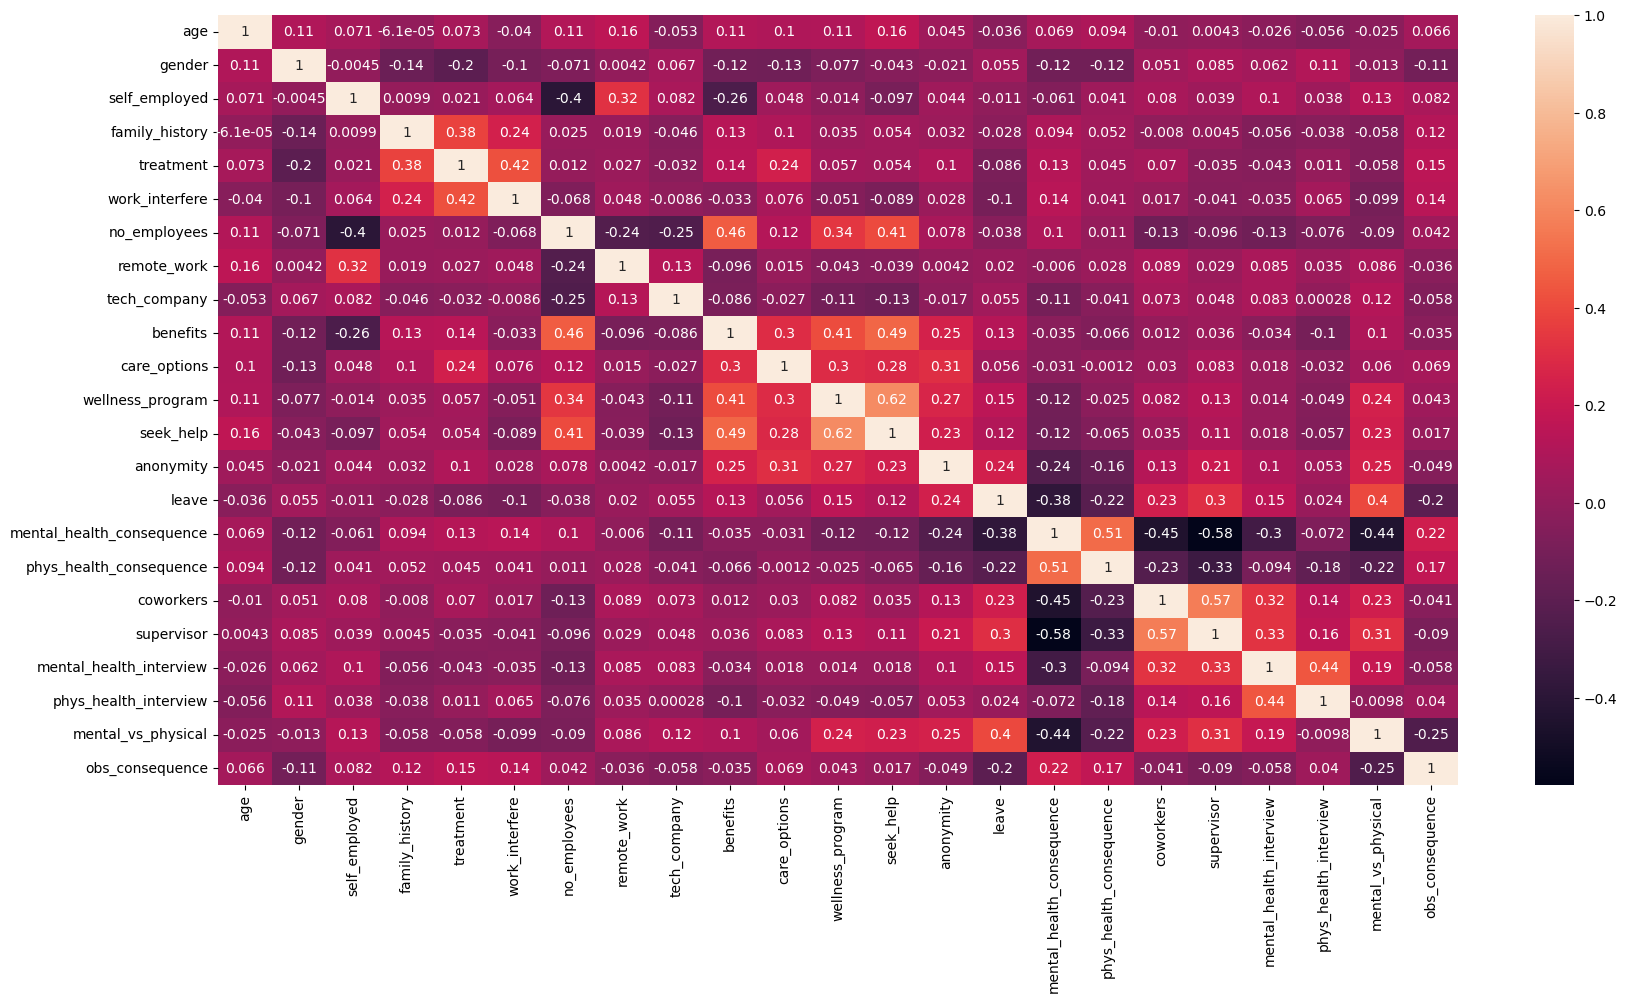

In [16]:
df_corr = df_coded.corr()

plt.figure(figsize=(20,10))
sns.heatmap(df_corr, annot=True)

plt.show()  # we have so many columns so it not useful to create a heat map.

Well we have so many columns so treatimg heat map is not the best. I will create line plots to certain columns to find some patterns

## Data Featuring

### Creating 2 new columns. 

#### Workplace Score:

We have 6 columns that tell if the workplace of the surveyed person has any resource to help with mental health.

So for each column, if the workplace has a resource they scores 1 and -1 if they do not have a resouce.

for example: if a workplace which has all 6 resources, its scores is 6 and similarly if a workplace does not have any resource its score is -6.


#### willingness Score:

If the interviews person is willing to talk about the mental health with coworker, supervisor, or ready to take a mental health then the person gets 3 scores and if the person is not ready to do none of them then the willingness score is -3

In [17]:
workplace_resouces = ['benefits', 
                      'wellness_program', 
                      'anonymity', 
                      'seek_help', 
                      'leave']

willingness = ['coworkers',
               'supervisor',
               'mental_health_interview']

# add columns together
df_coded['workplace_score'] = df_coded.benefits+ df_coded.wellness_program + df_coded.seek_help + df_coded.leave + df_coded.anonymity
df_coded['willingness_score'] = df_coded.coworkers + df_coded.supervisor + df_coded.mental_health_interview

## 3.Data Visualization

In [18]:
df.reset_index(inplace=True)
df_coded.reset_index(inplace=True)

In [19]:
df_merge = df_coded[['workplace_score', 'willingness_score']]

In [20]:
df = df.join(df_merge, on='index', how='left')

#### Creating a serious of line plots to show the correlation of willingness score with certain columns.

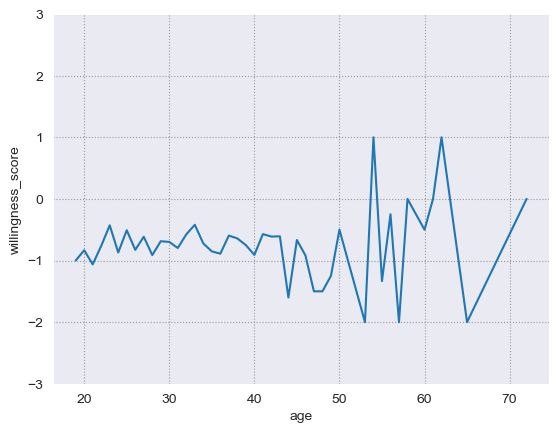

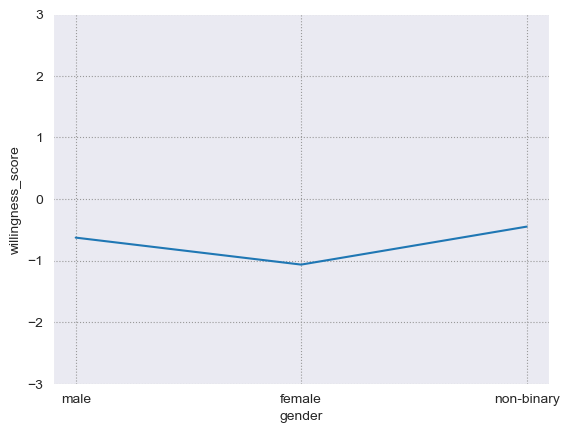

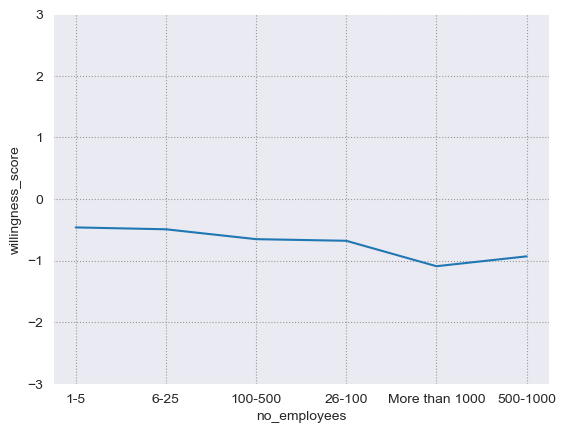

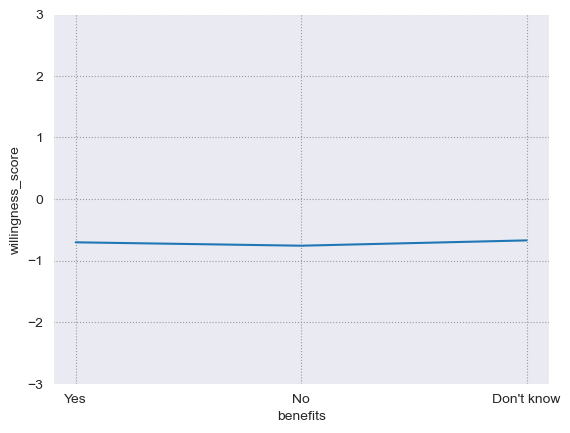

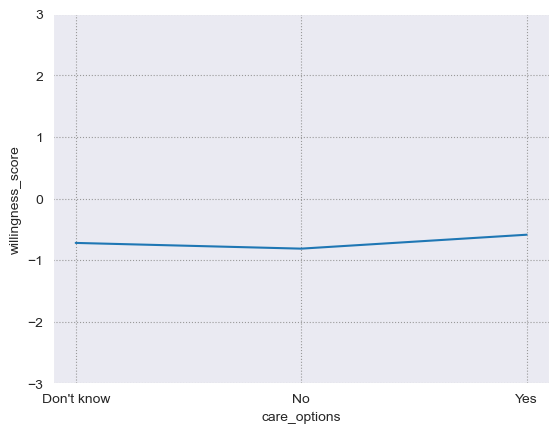

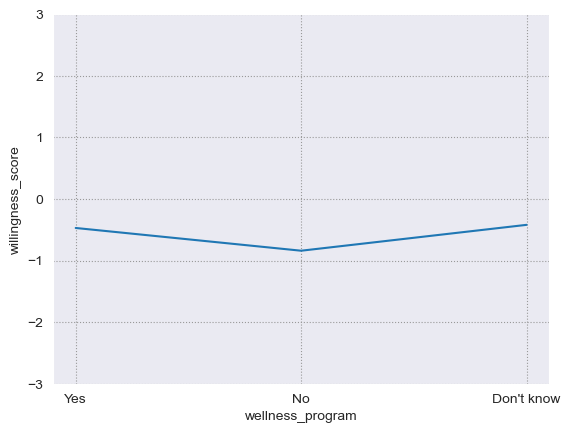

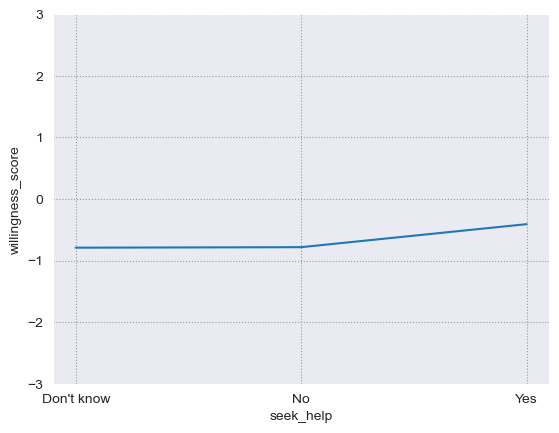

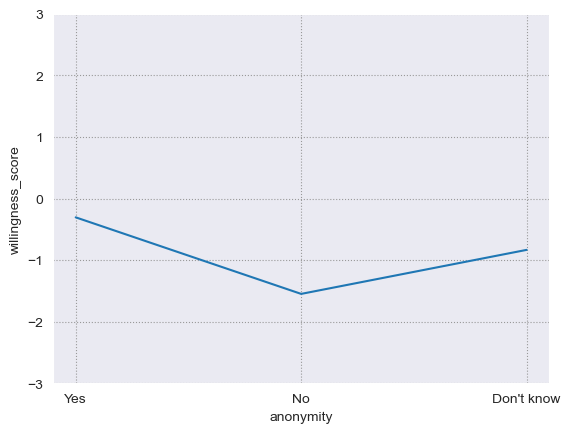

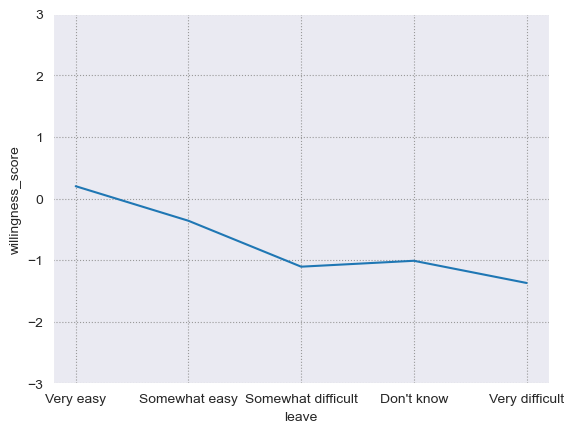

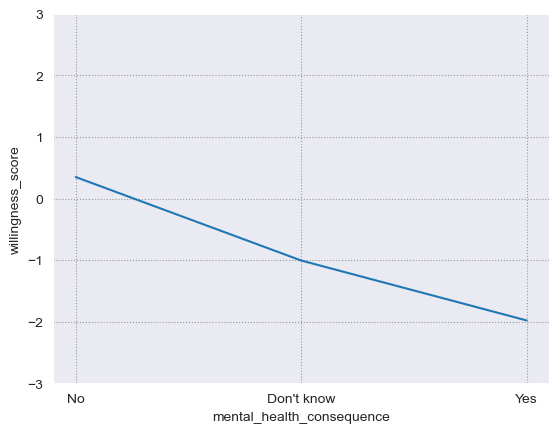

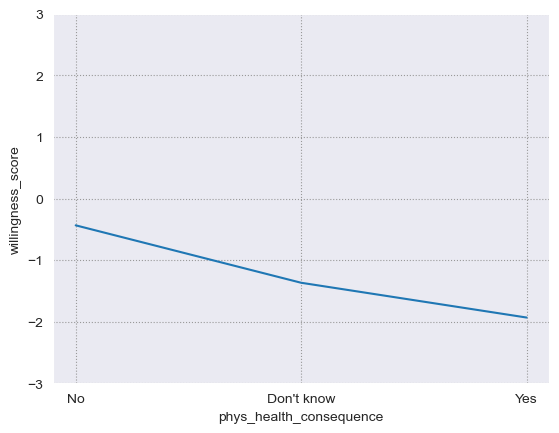

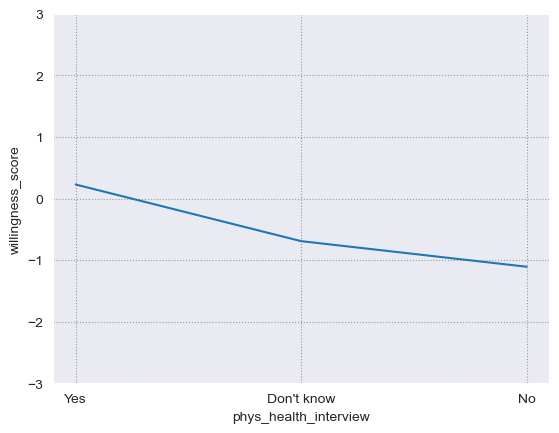

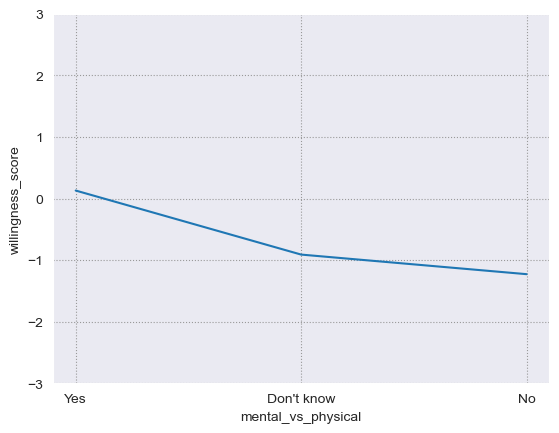

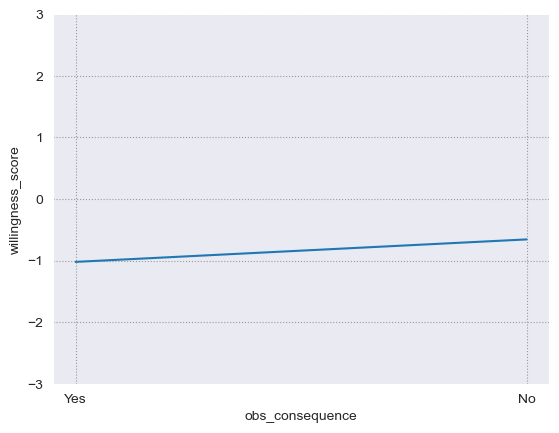

In [21]:
columns = ['age', 'gender', 'no_employees',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

for x in columns:
    sns.lineplot(x = df[x], y=df['willingness_score'], ci=None)
    plt.ylim(-3,3)
    plt.show()

### Conlcusion:

#### correlations: 

1. Anonymity: People are more willing to speak about mental health if their anonymity is maintained.
2. Leave:     It shows workplaces with easy to take mental health  leaves has more people who are willing to speak.
3. mental health consequences: People who think discussing mental health with employer will have negative consequences are less willing to speak.
4. Physical health consequences: People who think discussing physical health with employer will have negative consequences are less willing to speak.
5. Non-binary people are more likely to speak than males and males are more likely to speak than females.
6. People with age above 60 are more willing than people who are less than 60

#### No correlation
1. Benefit
2. care option
3. wellness programs
4. seek help 
These all correlate very little to not at all to willing to speak about mental health

### Now lets do the same for workplace score

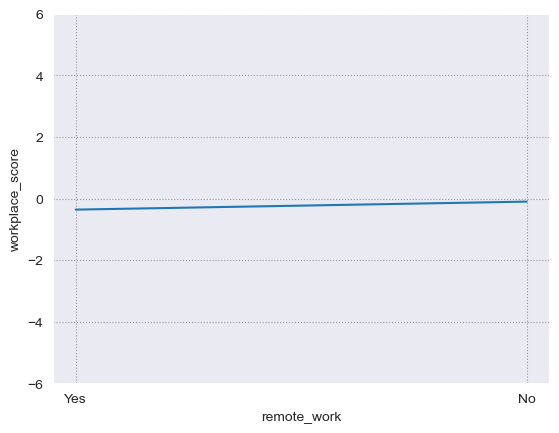

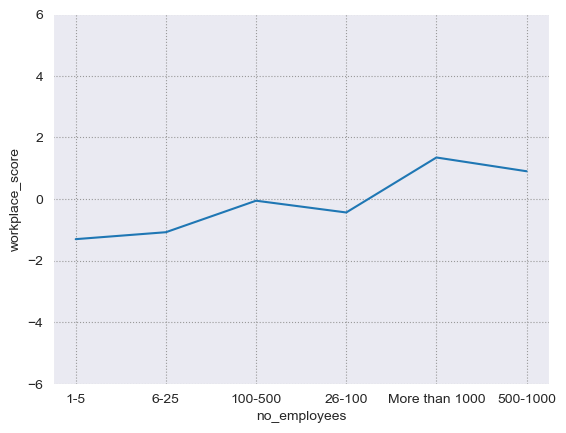

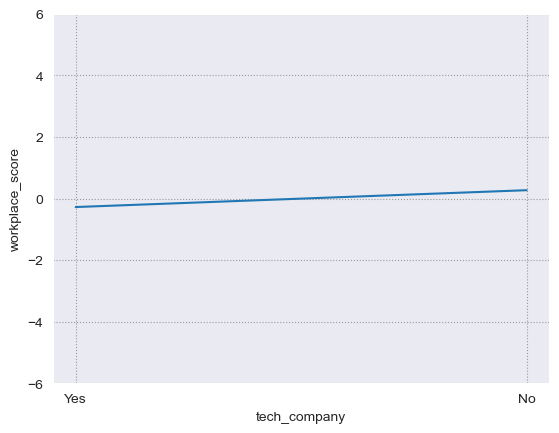

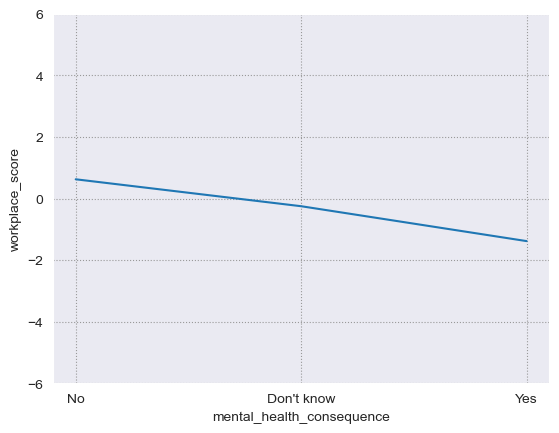

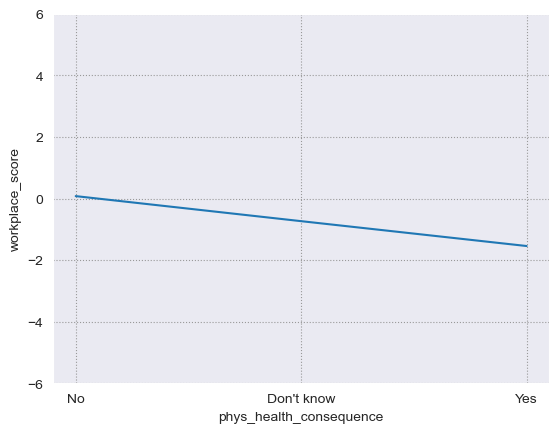

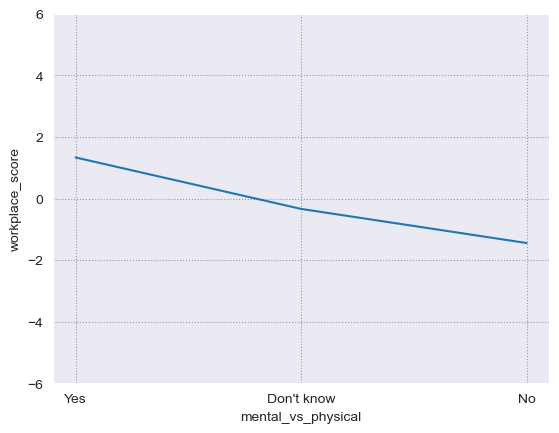

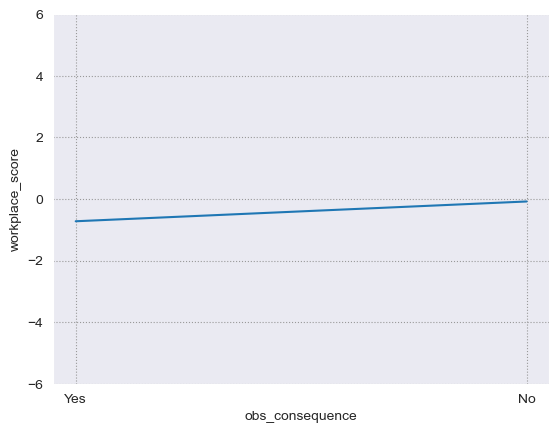

In [22]:
columns = ['remote_work', 'no_employees', 'tech_company', 'mental_health_consequence',
       'phys_health_consequence',
       'mental_vs_physical', 'obs_consequence']

for x in columns:
    sns.lineplot(x = df[x],y = df['workplace_score'], ci=None)
    plt.ylim(-6,6)
    plt.show()

## Conclusion:

### Correlations:

1. no. of employees: Large workplaces have better workplace score.
2. mental health consequences: Companies have bad workplace score where people believe discussing mental health will have negative consequences.
3. Physical health consequences: Companies have bad workplace score where people believe discussing physical health will have negative consequences.
4. mental vs physical: a workplace has better score where employers takes mental health as serious as physical health

### No correlations
1. Tech company
2. observes consequences

these have little to no correlation with the workplace scores.

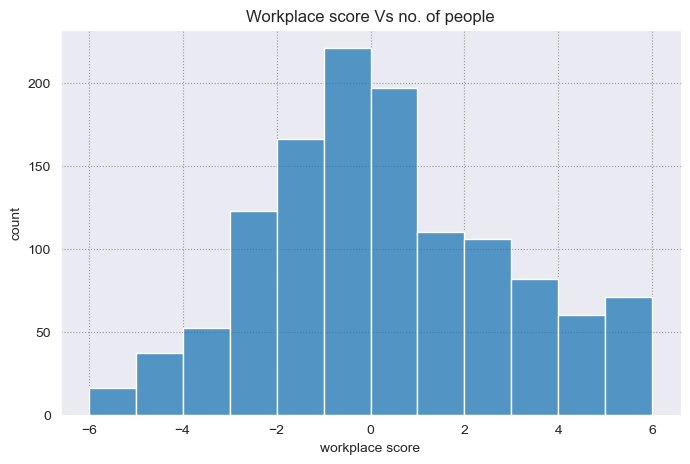

In [23]:
# plotting a histogram to show the how many people from the survey has what workplace score.
plt.figure(figsize=(8,5))
sns.histplot(df_coded['workplace_score'], bins=12)

plt.xlabel('workplace score')
plt.ylabel('count')
plt.title('Workplace score Vs no. of people')

plt.show()

We can see that most of the people work where the workplace score is between -1 and 1

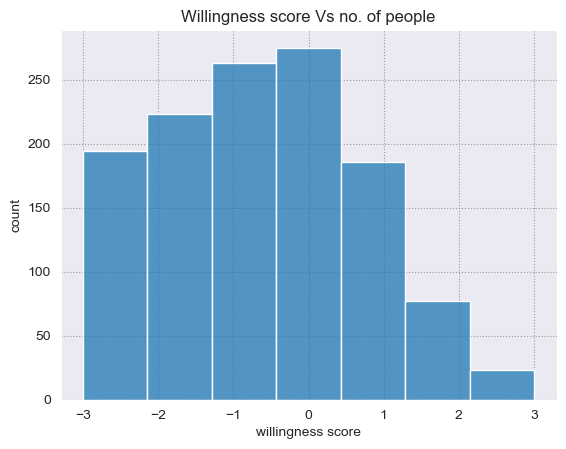

In [24]:
# plotting a histplot is show the count of people for willingness score.

sns.histplot(df_coded['willingness_score'], bins=7)

plt.xlabel('willingness score')
plt.ylabel('count')
plt.title('Willingness score Vs no. of people')

plt.show()

We can see that high number of people are not willing to speak

In [25]:
# interestingly to check the proportion of people aware of services I needed to recode the values in the
# care options column from 'No' = -1 to 'No' = 0

df_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)
df_coded.pivot_table(index=['workplace_score'], values=['care_options'], aggfunc= lambda x: sum(x)/len(x))


,care_options
workplace_score,
-6,0.562500
-5,0.405405
-4,0.307692
-3,0.211382
-2,0.192771
-1,0.226244
0,0.289340
1,0.390909
2,0.405660


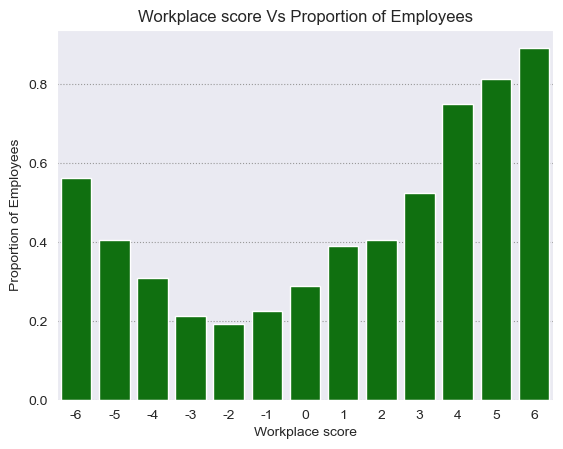

In [26]:
# this plot shows what proportion of the surveyed people knows about the care option their workplace is providing.

sns.barplot(x= 'workplace_score', y= 'care_options', data= df_coded, ci=None, color='green')
plt.xlabel('Workplace score')
plt.ylabel('Proportion of Employees')
plt.title('Workplace score Vs Proportion of Employees')

plt.show()


In [27]:
# group by variable of interest, create a label and rename columns


# Making a new dataframe which shows the willingness score based family history of mental health.
family_data = df_coded.groupby('family_history').agg({'willingness_score':'mean'}).reset_index()
family_data['label'] = ['Family History']*len(family_data)
family_data.rename(columns= {'family_history':'Answer'}, inplace=True)

# making a new dataframe to show the willingness score based on people who took mental health treatment and who did not.
treatment_data = df_coded.groupby('treatment').agg({'willingness_score':'mean'}).reset_index()
treatment_data['label'] = ['Treatment']*len(treatment_data)
treatment_data.rename(columns= {'treatment':'Answer'}, inplace=True)


# Combining both the dataframes.
willingness_variables = pd.concat([family_data, treatment_data], axis=0)
willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)
willingness_variables.Answer.replace(to_replace=1, value='Yes', inplace=True)

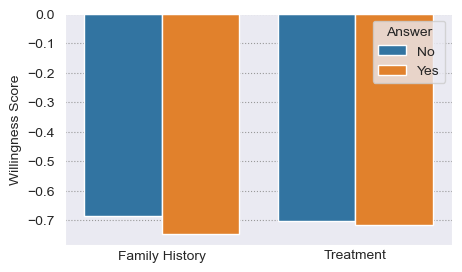

In [28]:
# making a category bar plot
fig, ax = plt.subplots(figsize=(5, 3))

bars= sns.barplot(x="label", y="willingness_score", hue="Answer", 
            data=willingness_variables)


bars.set(xlabel= '', ylabel= 'Willingness Score')
bars.tick_params(axis='x', which='both', length=0)
plt.show()

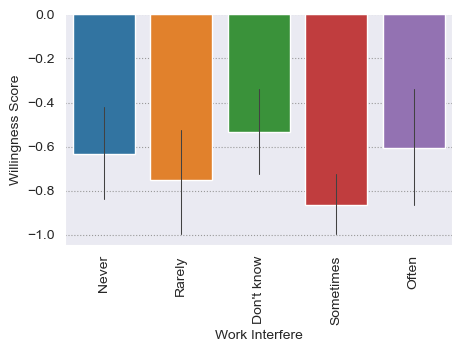

In [29]:
xlabel = 'Work Interfere'
ylabel = 'Willingness Score'

fig, ax = plt.subplots(figsize=(5, 3))
bars = sns.barplot(x= 'work_interfere', y= 'willingness_score', data= df_coded, errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel)
bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=90)

plt.show()

In [30]:
# to reach the answer to our main question
willingness_treatment = df_coded.groupby('workplace_score').agg({'willingness_score':'mean'})
willingness_treatment

,willingness_score
workplace_score,
-6,-2.500000
-5,-1.405405
-4,-1.115385
-3,-1.235772
-2,-0.789157
-1,-0.710407
0,-0.695431
1,-0.636364
2,-0.386792


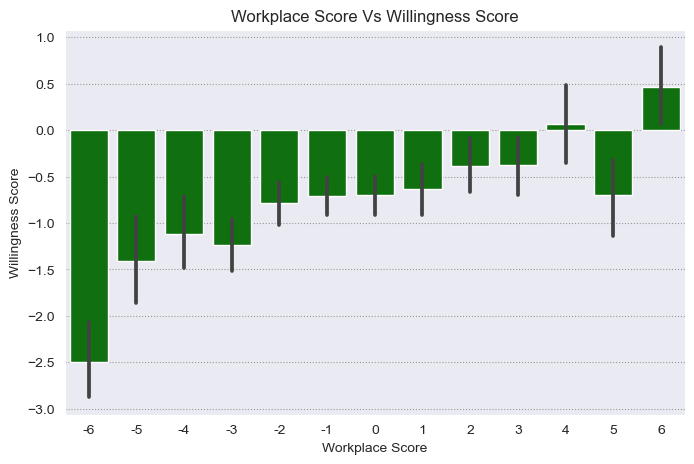

In [31]:
# create a bar plot with the average willingness score for each workplace score category

plt.figure(figsize=(8,5))
bars = sns.barplot(x='workplace_score', y='willingness_score', data= df_coded, color='green')

plt.xlabel('Workplace Score')
plt.ylabel('Willingness Score')
plt.title('Workplace Score Vs Willingness Score')

plt.show()

In [32]:
# I also did this analysis for gender but I find it slightly less interesting.
gender_willingness = df_coded.groupby('gender', as_index=False).agg({'willingness_score':'mean'})
gender_willingness

,gender,willingness_score
0,-1,-0.450000
1,0,-1.066116
2,1,-0.628192


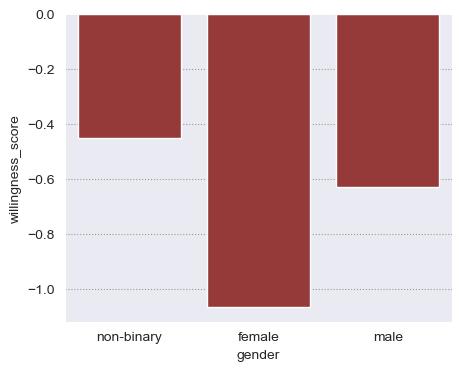

In [33]:
plt.figure(figsize=(5,4))
bars = sns.barplot(x='gender', y='willingness_score', data= gender_willingness, color='brown')
bars.set_xticklabels(['non-binary', 'female', "male"])

plt.show()

C:\Users\namra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


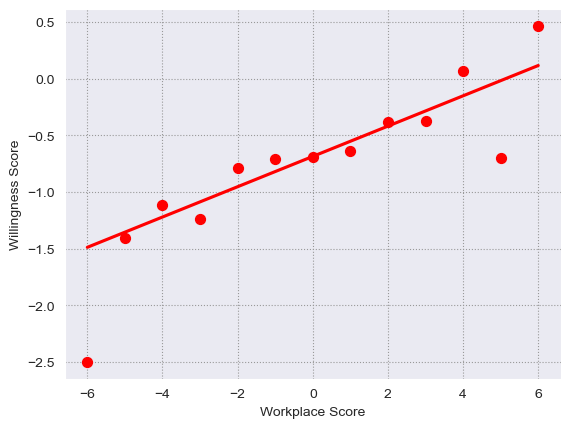

In [34]:
x = df_coded['workplace_score']
y = df_coded['willingness_score']


xlabel = 'Workplace Score'
ylabel = 'Willingness Score'

reg = sns.regplot(x, y, x_estimator=np.mean, color='r', ci=None)

reg.set(xlabel= xlabel, ylabel= ylabel)

plt.show()